In [23]:
import kagglehub
import pandas as pd
import numpy as np
path = kagglehub.dataset_download("sgpjesus/bank-account-fraud-dataset-neurips-2022")

print("Path to dataset files:", path)
new_df = pd.read_csv(path+"/Base.csv")





Using Colab cache for faster access to the 'bank-account-fraud-dataset-neurips-2022' dataset.
Path to dataset files: /kaggle/input/bank-account-fraud-dataset-neurips-2022


In [24]:
new_df['month']

,month
0,0
1,0
2,0
3,0
4,0
...,...
999995,7
999996,7
999997,7
999998,7


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

file_path = '/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv'
data_raw = pd.read_csv(path+"/Base.csv")


df_fraud = data_raw[data_raw['fraud_bool'] == 1]
df_non_fraud = data_raw[data_raw['fraud_bool'] == 0]

from sklearn.utils import resample
df_non_fraud_downsampled = resample(
    df_non_fraud,
    replace=False,
    n_samples=len(df_fraud),
    random_state=42
)

df_balanced = pd.concat([df_fraud, df_non_fraud_downsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

categorical_features = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
numerical_features = df_balanced.drop(columns=['fraud_bool', 'month'] + categorical_features).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

train_data = df_balanced[df_balanced['month'].between(0, 5)]
test_data = df_balanced[df_balanced['month'].between(6, 7)]

train_data = train_data.drop(columns=['month'])
test_data = test_data.drop(columns=['month'])

X_train = train_data.drop('fraud_bool', axis=1)
y_train = train_data['fraud_bool']
X_test = test_data.drop('fraud_bool', axis=1)
y_test = test_data['fraud_bool']

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

numerical_feature_names = preprocessor.transformers_[0][2]
categorical_feature_names = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features)
feature_names = numerical_feature_names + categorical_feature_names.tolist()

X_train_final = pd.DataFrame(X_train_resampled, columns=feature_names)
X_test_final = pd.DataFrame(X_test_transformed, columns=feature_names)

print("--- Data Processing Complete ---")
print(f"Original data shape: {data_raw.shape}")
print(f"Balanced data shape: {df_balanced.shape}")
print(f"Processed train shape: {X_train_final.shape}")
print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())
print("\nFirst 5 rows of processed training data:")
print(X_train_final.head())


--- Data Processing Complete ---
Original data shape: (1000000, 32)
Balanced data shape: (22058, 32)
Processed train shape: (17566, 46)

Class distribution after SMOTE:
fraud_bool
0    8783
1    8783
Name: count, dtype: int64

First 5 rows of processed training data:
     income  name_email_similarity  prev_address_months_count  \
0  0.681025               1.006740                  -0.314392   
1 -0.352413              -0.102600                  -0.314392   
2 -0.696892              -0.685287                  -0.314392   
3 -1.730330               0.826459                  -0.314392   
4 -0.007934              -0.764347                  -0.314392   

   current_address_months_count  customer_age  days_since_request  \
0                      0.024997     -0.546087           -0.183208   
1                      0.731980     -0.546087           -0.186624   
2                      1.517517      0.970010           -0.192496   
3                     -0.580989     -1.304135            0.249135


--- Training Random Forest ---
Random Forest - Train Accuracy: 1.0000, Test Accuracy: 0.7896
Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.73      0.81      0.77      2246
       Fraud       0.84      0.77      0.80      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124



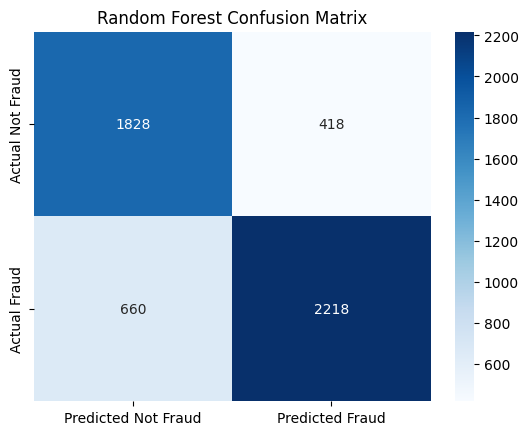


--- Feature Importance for Random Forest ---
                        feature  importance
0  current_address_months_count    0.074966
1             credit_risk_score    0.066308
2             device_os_windows    0.063462
3         name_email_similarity    0.061655
4        intended_balcon_amount    0.045483
5                        income    0.045154
6                  zip_count_4w    0.041552
7                   velocity_4w    0.040951
8            days_since_request    0.040752
9     session_length_in_minutes    0.039858

--- Training Gradient Boosting ---
Gradient Boosting - Train Accuracy: 0.8262, Test Accuracy: 0.7978
Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.75      0.81      0.78      2246
       Fraud       0.84      0.78      0.81      2878

    accuracy                           0.80      5124
   macro avg       0.80      0.80      0.80      5124
weighted avg       0.80      0.80      0.80      5124



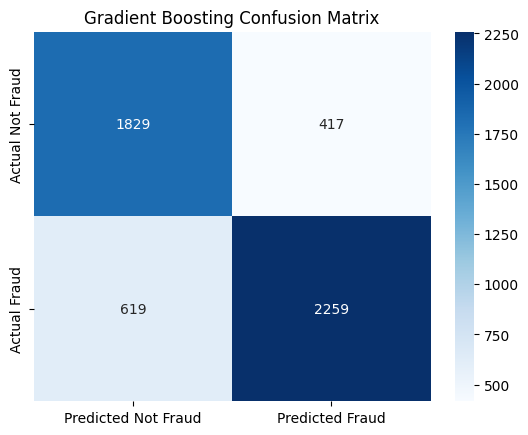


--- Feature Importance for Gradient Boosting ---
                        feature  importance
0             device_os_windows    0.207961
1  current_address_months_count    0.089978
2             housing_status_BE    0.058433
3             credit_risk_score    0.058259
4                        income    0.056299
5               has_other_cards    0.055576
6            keep_alive_session    0.055101
7         name_email_similarity    0.048378
8              phone_home_valid    0.048011
9     prev_address_months_count    0.046037

--- Training AdaBoost ---
AdaBoost - Train Accuracy: 0.8115, Test Accuracy: 0.7867
Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.72      0.83      0.77      2246
       Fraud       0.85      0.75      0.80      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124



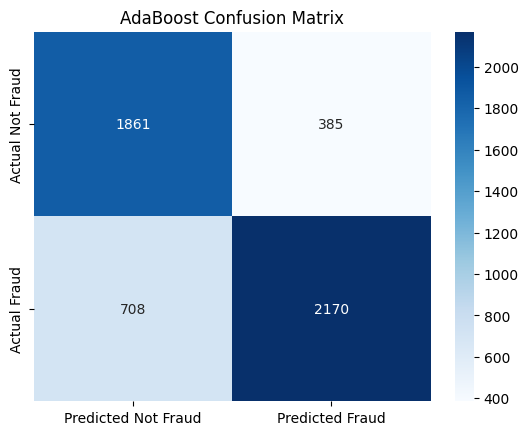


--- Feature Importance for AdaBoost ---
                        feature  importance
0             device_os_windows    0.090093
1  current_address_months_count    0.067353
2                        income    0.067293
3         proposed_credit_limit    0.063616
4               has_other_cards    0.063393
5             housing_status_BE    0.048968
6             credit_risk_score    0.047097
7            keep_alive_session    0.045854
8     device_distinct_emails_8w    0.044462
9         name_email_similarity    0.042295

--- Training Logistic Regression ---
Logistic Regression - Train Accuracy: 0.7985, Test Accuracy: 0.7859
Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.72      0.83      0.77      2246
       Fraud       0.85      0.75      0.80      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124



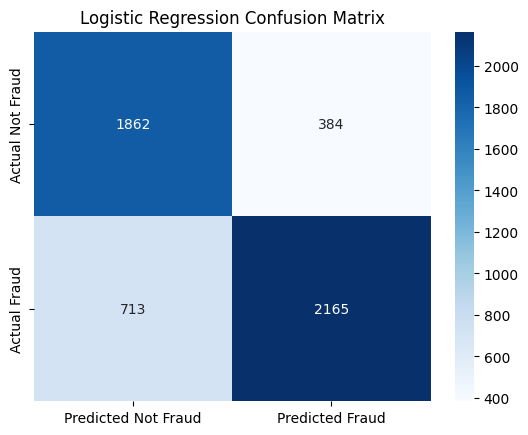


--- Feature Importance for Logistic Regression ---
                feature  coefficient
0     housing_status_BE    -1.491974
1     device_os_windows     1.346890
2     housing_status_BG    -1.259579
3     housing_status_BB    -1.220243
4     housing_status_BC    -1.179528
5  employment_status_CF    -1.028682
6         device_os_x11     0.923923
7       payment_type_AC     0.919153
8   device_os_macintosh     0.863980
9  employment_status_CE    -0.858249


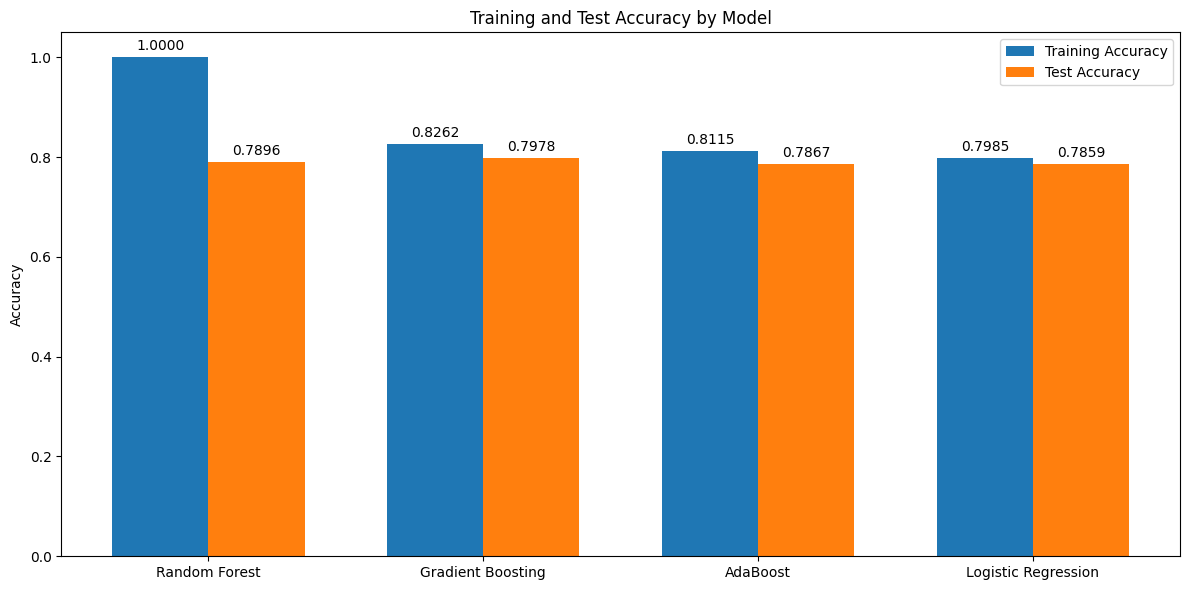


--- Summary of Model Accuracies ---
Random Forest: 0.7896
Gradient Boosting: 0.7978
AdaBoost: 0.7867
Logistic Regression: 0.7859


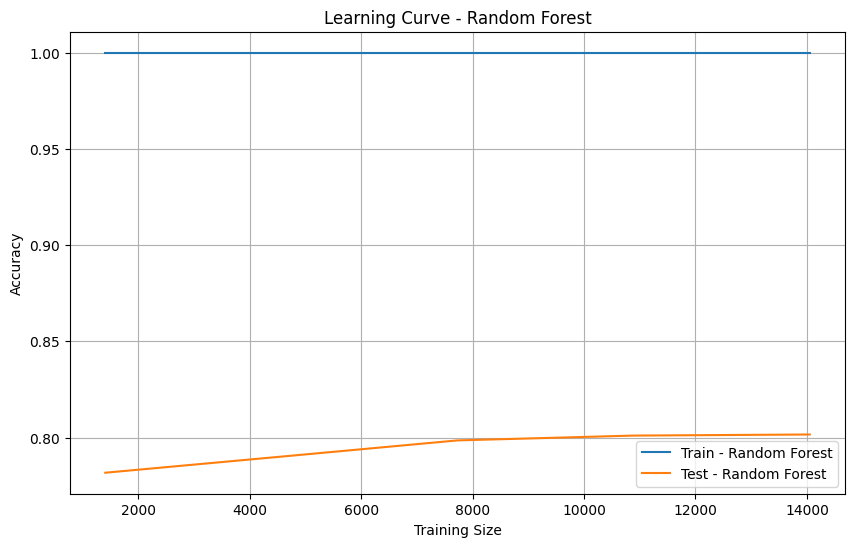


Random Forest - Cross-Validation Mean Accuracy: 0.8043
Random Forest - Cross-Validation Scores: [0.80677291 0.81184173 0.79077711 0.79675491 0.81525761]


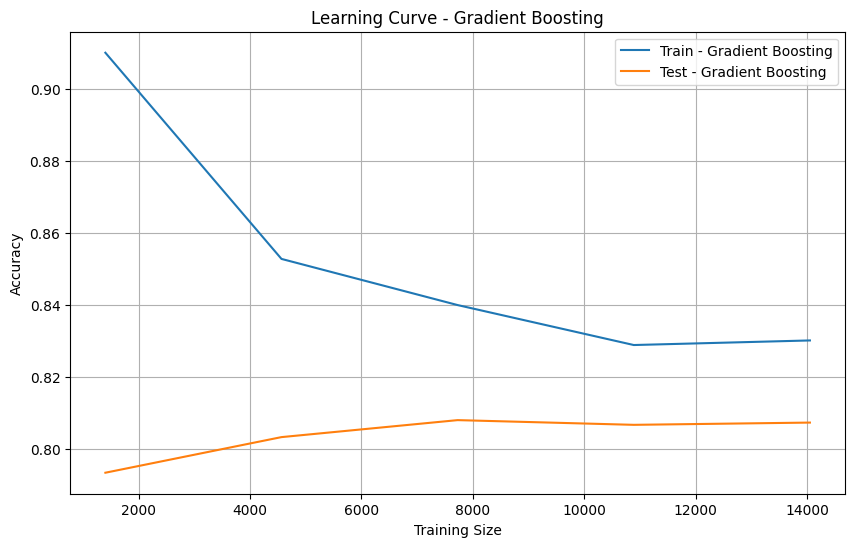


Gradient Boosting - Cross-Validation Mean Accuracy: 0.8071
Gradient Boosting - Cross-Validation Scores: [0.81217985 0.8246513  0.79504697 0.80301736 0.80045545]


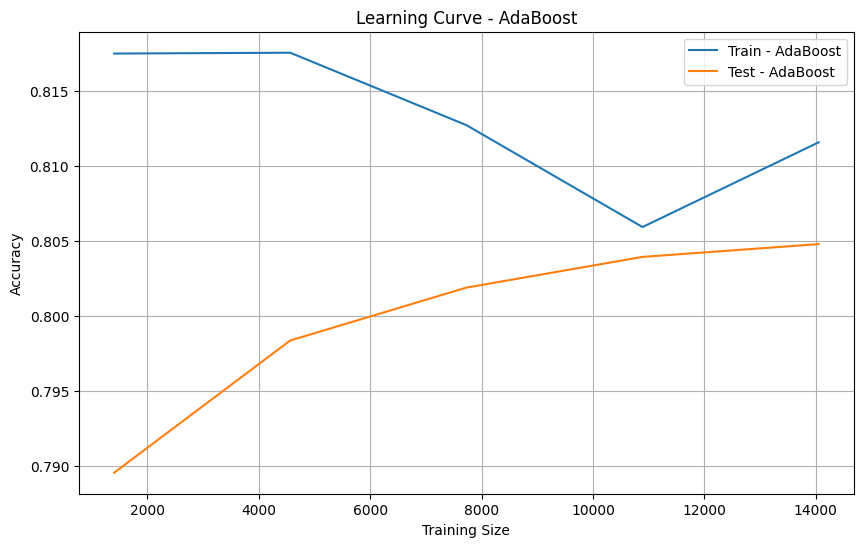


AdaBoost - Cross-Validation Mean Accuracy: 0.8048
AdaBoost - Cross-Validation Scores: [0.81075697 0.81781953 0.79732422 0.79703957 0.80102477]


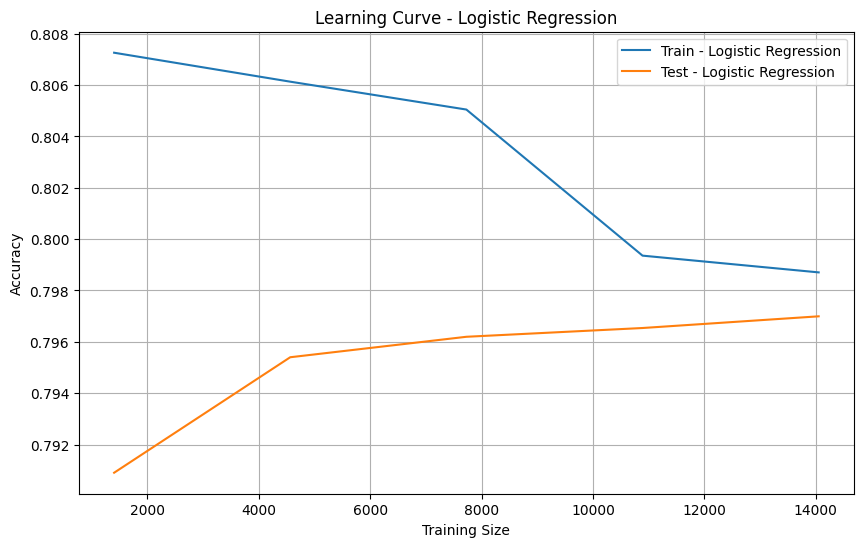


Logistic Regression - Cross-Validation Mean Accuracy: 0.7969
Logistic Regression - Cross-Validation Scores: [0.80136596 0.81753487 0.78935383 0.78337603 0.79305437]


In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Import pandas for DataFrame

# --- Ensure numeric arrays for models ---
X_train_numeric = X_train_final.values
X_test_numeric = X_test_final.values
y_train_numeric = y_train_resampled.values
y_test_numeric = y_test.values

# --- Define models ---
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    # "SVM": SVC(random_state=42, class_weight='balanced') # SVM does not directly provide feature importances in the same way
}

# --- Evaluate models and plot results ---
train_results = {}
results = {}

for name, model in models.items():
    # Train model on training data
    print(f"\n--- Training {name} ---")
    model.fit(X_train_numeric, y_train_numeric)

    # Predict on train and test
    y_train_pred = model.predict(X_train_numeric)
    y_test_pred = model.predict(X_test_numeric)

    # Calculate accuracy for train and test
    train_acc = accuracy_score(y_train_numeric, y_train_pred)
    test_acc = accuracy_score(y_test_numeric, y_test_pred)

    # Store accuracy results
    train_results[name] = train_acc
    results[name] = test_acc

    # Print classification report and confusion matrix
    print(f"{name} - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_numeric, y_test_pred, target_names=['Not Fraud', 'Fraud']))

    # Confusion Matrix
    cm = confusion_matrix(y_test_numeric, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Not Fraud', 'Predicted Fraud'],
                yticklabels=['Actual Not Fraud', 'Actual Fraud'])
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    # --- Feature Importance Analysis ---
    print(f"\n--- Feature Importance for {name} ---")
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
        feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
        print(feature_importances.head(10)) # Print top 10 features
    elif hasattr(model, 'coef_'):
        # For linear models like Logistic Regression
        # For binary classification, coef_ is shape (1, n_features)
        coef = model.coef_[0] if model.coef_.ndim > 1 else model.coef_
        feature_importances = pd.DataFrame({'feature': feature_names, 'coefficient': coef})
        # Sort by absolute value of coefficient to see impact
        feature_importances['abs_coefficient'] = abs(feature_importances['coefficient'])
        feature_importances = feature_importances.sort_values('abs_coefficient', ascending=False).reset_index(drop=True)
        print(feature_importances[['feature', 'coefficient']].head(10)) # Print top 10 features by absolute coefficient
    else:
        print("Feature importance not available for this model type.")


# --- Plot training vs test accuracy comparison ---
# Prepare data for plotting
model_names = list(results.keys())
test_accuracies = list(results.values())
train_accuracies = list(train_results.values())

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

# Add labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Training and Test Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Add accuracy values on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# --- Summary of accuracies ---
print("\n--- Summary of Model Accuracies ---")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# --- Learning Curves and Cross-Validation ---
# Plot Learning Curves and Cross-Validation Scores
for name, model in models.items():
    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(model, X_train_numeric, y_train_numeric, cv=5, n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label=f'Train - {name}')
    plt.plot(train_sizes, test_mean, label=f'Test - {name}')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve - {name}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_numeric, y_train_numeric, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"\n{name} - Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}")
    print(f"{name} - Cross-Validation Scores: {cv_scores}")